# LA - 30min

In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = '1'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
plt.rcParams['figure.dpi'] = 100
np.random.seed(123456)

In [3]:
data_path='../data/traffic_la6_tid_diw_offset6.npz'

data = np.load(data_path)

In [4]:
def get_sparsity(adj):
    avg_deg = np.mean([np.count_nonzero(x) for x in adj])
    return 100*(1 - (np.count_nonzero(adj) / (adj.shape[0]**2))), avg_deg

In [5]:
adj0, trX0, trY0, valX0, valY0, teX0, teY0 = data['gmat'], data['trainx'], data['trainy'], data['valx'], data['valy'], data['testx'], data['testy']
nodes = adj0.shape[0]

In [6]:
predY0_mask = (teY0 > 0)
print(np.sum(predY0_mask), predY0_mask.size, np.sum(predY0_mask) / predY0_mask.size)

1246258 1417950 0.8789153355195881


In [7]:
print(trX0.shape)
trX0 = np.concatenate([trX0, valX0])
trY0 = np.concatenate([trY0, valY0])
print(trX0.shape)

(23974, 207, 8)
(27399, 207, 8)


In [8]:
# handle missing values

from sklearn.impute import SimpleImputer

shapeX = trX0.shape
impX = SimpleImputer(missing_values=0, strategy='median')
impX.fit(trX0.reshape(shapeX[0], -1))
trX0 = impX.transform(trX0.reshape(shapeX[0], -1)).reshape(shapeX)
teX0 = impX.transform(teX0.reshape(teX0.shape[0], -1)).reshape(teX0.shape)

shapeY = trY0.shape
impY = SimpleImputer(missing_values=0, strategy='median')
impY.fit(trY0.reshape(shapeY[0], -1))
trY0 = impY.transform(trY0.reshape(shapeY[0], -1)).reshape(shapeY)
teY0 = impY.transform(teY0.reshape(teY0.shape[0], -1)).reshape(teY0.shape)

In [9]:
def normalize_data(data, mu, std):
    res = (data-mu) / std
    return res

def unnormalize_data(data, mu, std):
    res = data * std + mu
    return res

In [10]:
def get_subg(trX, trY, teX, teY, gmat, subn=100):
    return trX[:, :subn, :], trY[:, :subn, :], teX[:, :subn, :], teY[:, :subn, :], gmat[:subn, :subn]

In [11]:
subn=100

nodes=subn
trX0, trY0, teX0, teY0, adj0 = get_subg(trX0, trY0, teX0, teY0, adj0, subn=subn)

In [12]:
np.max(adj0[adj0>0]), np.min(adj0[adj0>0])

(1.0, 0.10008398)

In [13]:
get_sparsity(adj0)

(95.3, 4.7)

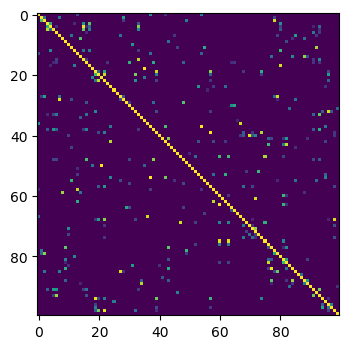

In [14]:
plt.imshow(adj0)

In [15]:
# def thresh(adj, t=0.1):
#     adj[adj<t] = 0
#     adj[adj>=t] = 1
#     return adj

def thresh(adj0, dg=3):
    adj = np.zeros(adj0.shape)
    for i in range(adj.shape[0]):
        adj[i, np.argsort(-adj0[i, :])[:dg]] = 1
    adj = np.minimum(adj, adj0)
    adj[adj>0] = 1
    return adj

In [16]:
adj = thresh(np.maximum(adj0, adj0.T), dg=5)
# adj = thresh(np.maximum(adj0, adj0.T), t=0.7)
get_sparsity(adj)

(95.42, 4.58)

adj = np.eye(adj.shape[0])

trX0 = trX0[:, :, 2:]
teX0 = teX0[:, :, 2:]

In [17]:
mu_trX0, std_trX0 = np.mean(trX0, axis=0, keepdims=True), np.std(trX0, axis=0, keepdims=True)
mu_trY0, std_trY0 = np.mean(trY0, axis=0, keepdims=True), np.std(trY0, axis=0, keepdims=True)
# mu_teX0, std_teX0 = np.mean(teX0, axis=0), np.std(teX0, axis=0)
# mu_teY0, std_teY0 = np.mean(teY0, axis=0), np.std(teY0, axis=0)

In [18]:
trX = normalize_data(trX0, mu_trX0, std_trX0)
trY = normalize_data(trY0, mu_trY0, std_trY0)

In [19]:
perm = np.random.permutation(trX.shape[0])
trX = trX[perm]
trY = trY[perm]

In [20]:
teX = normalize_data(teX0, mu_trX0, std_trX0)
teY = normalize_data(teY0, mu_trY0, std_trY0)

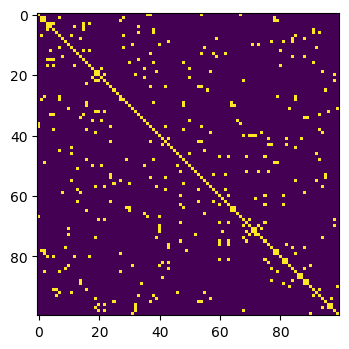

In [21]:
plt.imshow(adj)

In [22]:
M = 20

Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (20, 100, 8)


In [23]:
# build model
# adj_identity = np.identity(adj.shape[0])  # without nb information
adj = adj.astype('float64')
input_adj = adj # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)

# Train

In [24]:
trX.shape

(27399, 100, 8)

In [25]:
trY.shape

(27399, 100, 1)

In [26]:
with gpflow.defer_build():
    m_dgpg = DGPG(trX, trY, Z, [8,2,1,1], Gaussian(), input_adj,
                  agg_op_name='concat3d', ARD=True,
                  is_Z_forward=True, mean_trainable=True, out_mf0=True,
                  num_samples=20, minibatch_size=40,
                  kern_type='RBF'
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
m_dgpg.compile()
model = m_dgpg

input-output dim (8(agg:800)->2)
input-output dim (2(agg:200)->1)
input-output dim (1(agg:100)->1)
input-output dim (1(agg:100)->1)
func __init__ consumed 29.3s


In [27]:
%%time

session = m_dgpg.enquire_session()
global_step = mon.create_global_step(session)

CPU times: user 144 ms, sys: 4 ms, total: 148 ms
Wall time: 144 ms


# Run

In [ ]:
maxiter=5000

model.trainable = True
exp_path="./exp/la6tiddiw-tv-subg100-offset6-thdg5-M20-8-2-1-1-1-5k-rbf"
optimiser = gpflow.train.AdamOptimizer(0.01)
# exp_path="./exp/temp5"

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

checkpoint_task = mon.CheckpointTask(checkpoint_dir=exp_path)\
        .with_name('checkpoint')\
        .with_condition(mon.PeriodicIterationCondition(15))\

with mon.LogdirWriter(exp_path) as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task, checkpoint_task] # [print_task, tensorboard_task]
    
       
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)

/home/linaiqi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/linaiqi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/linaiqi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
model.as_pandas_table()

In [ ]:
# from jack_utils.my_metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def np_rmse(y_true, y_pred, mask=predY0_mask[:, :subn, :]):
    # flatted mean, the same as attconv paper
    mask = mask.reshape(y_pred.shape)
    return np.sqrt(np.sum(mask*np.square(y_true-y_pred))/np.sum(mask))


def np_mae(y_true, y_pred, mask=predY0_mask[:, :subn, :]):
    mask = mask.reshape(y_pred.shape)
    return np.sum(mask*np.abs(y_true - y_pred))/np.sum(mask)

def np_mape(y_true, y_pred, mask=predY0_mask[:, :subn, :]):
    mask = mask.reshape(y_pred.shape)
    return np.sum(mask*np.abs((y_true-y_pred) / np.clip(np.abs(y_true), 1, None)))/np.sum(mask)

In [ ]:
def assess_model_rmse(model, X_batch, Y_batch, S = 10):
    m, v = model.predict_y(X_batch, S)
    pred = np.mean(m, axis=0)
    var = np.mean(v, axis=0)
    loss = np.sum((Y_batch.flatten()-pred.flatten())**2)
    return loss, pred, var

def batch_assess_rmse(model, X, Y, batch_size=1, S=10):
    n_batches = max(int(len(X)/batch_size), 1)
    rms = len(X) - n_batches*batch_size
    losses, preds, varis = [], [], []
    Xr, Yr = X[-rms:, :], Y[-rms:, :]
    for X_batch, Y_batch in zip(np.split(X[:n_batches*batch_size], n_batches), np.split(Y[:n_batches*batch_size], n_batches)):
        l, pred, vari = assess_model_rmse(model, X_batch, Y_batch, S=S)
        losses.append(l)
        preds.append(pred)
        varis.append(vari)
    if rms > 0:
        l, pred, vari = assess_model_rmse(model, Xr, Yr, S=S)
        losses.append(l)        
        preds.append(pred)
        varis.append(vari)
    ndata = Y.shape[0] * Y.shape[1]
    avg_loss = np.sqrt(np.sum(losses) / ndata)
    y_pred = np.concatenate(preds)
    y_var = np.concatenate(varis)
    return avg_loss, y_pred, y_var

In [ ]:
# make predictions of our model
sample_X0, sample_Y0 = teX0, teY0.squeeze()
sample_X, sample_Y = teX, teY.squeeze()
# S = 10  # sample_X.shape[0]*10
# m, v = model.predict_y(sample_X.reshape(sample_X.shape[0], -1), S)
# predY, predVY = np.mean(m, axis=0).squeeze(), np.mean(v, axis=0)

In [ ]:
teY0.shape

In [ ]:
%%time
pred_rmse, predY, varY = batch_assess_rmse(model, sample_X.reshape(sample_X.shape[0], -1), sample_Y.reshape(sample_Y.shape[0], -1))
print(pred_rmse)

In [ ]:
predY0 = unnormalize_data(predY[:,:,None], mu_trY0, std_trY0).squeeze()

metrics:	[mae | rmse | mape]
ours DGP:	 [3.456, 6.223, 0.074]
yesterday:	 [4.123, 7.806, 0.102]
day-mean:	 [4.052, 7.966, 0.097]
day_median:	 [4.053, 8.203, 0.1]


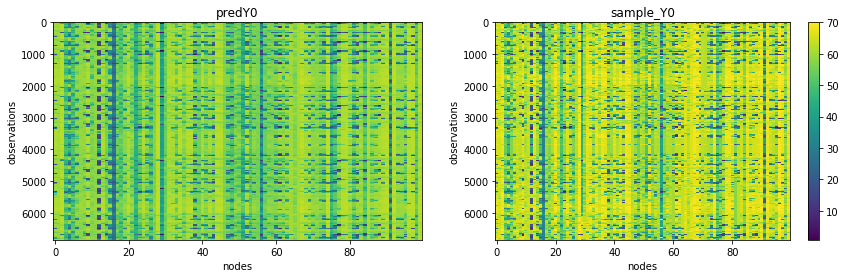

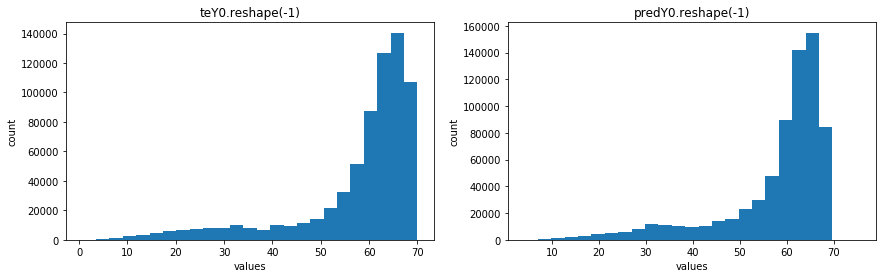

In [69]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_dgp = [np.round(f(predY0, sample_Y0.squeeze()), 3) for f in metrics]
e_last = [np.round(f(sample_X0[:,:,-1], sample_Y0.squeeze()), 3) for f in metrics]
e_ha = [np.round(f(sample_X0[:,:,2:].mean(axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
e_mid = [np.round(f(np.median(sample_X0[:,:,2:], axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('ours DGP:\t', e_dgp)
print('yesterday:\t', e_last)
print('day-mean:\t', e_ha)
print('day_median:\t', e_mid)

# visualization of prediction(mean)
fig, axs = plt.subplots(1, 2)
max_val = sample_Y0.max()*1.1
# for i, to_show in enumerate('predY0,sample_Y0,np.abs(predY0-sample_Y0)'.split(',')):
for i, to_show in enumerate('predY0,sample_Y0'.split(',')):
    im = axs[i].imshow(eval(to_show))
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('nodes'); axs[i].set_ylabel('observations');
fig.colorbar(im, ax=axs[-1])
plt.subplots_adjust(right=2)
plt.show()

# visualization of variance
fig, axs = plt.subplots(1, 2)
for i, to_show in enumerate('teY0.reshape(-1),predY0.reshape(-1)'.split(',')):
    im = axs[i].hist(eval(to_show), bins=25)
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('values'); axs[i].set_ylabel('count');
plt.subplots_adjust(right=2)
plt.show()

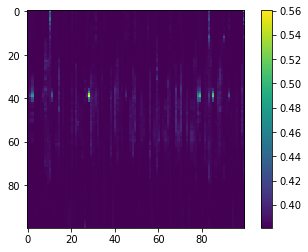

In [70]:
plt.imshow(varY[:100])
plt.colorbar()

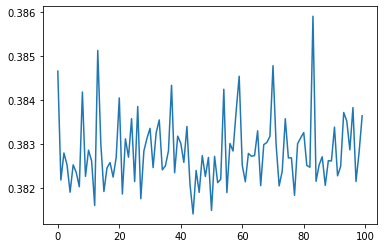

In [71]:
plt.plot(np.mean(varY, axis=0))

In [72]:
def plot_ls_node_k(k, l=0):
    fig, axs = plt.subplots(1, 2)
    axs[0].set_title('lengthscales of node %d' % k); axs[0].set_aspect('auto');
    ls = model.layers[l].kern.lengthscales.value
    ls0 = ls[k]
    idx = np.repeat(adj[k], 8).astype('bool')
    ls0n = ls0[idx]
    axs[0].plot(ls0n)
    
    axs[1].set_title('variancess of all nodes'); axs[0].set_aspect('auto');
    axs[1].plot(model.layers[l].kern.variance.value)
    
    plt.subplots_adjust(right=2)
    plt.show()

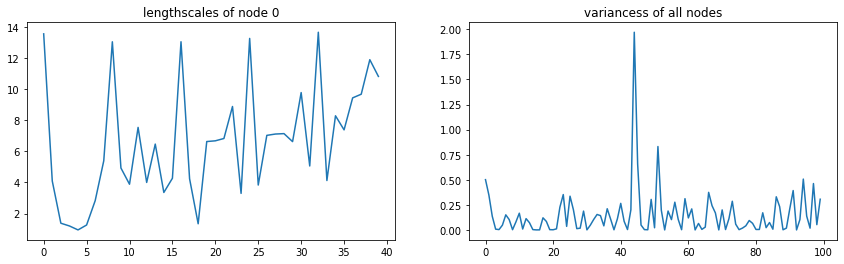

In [73]:
plot_ls_node_k(0)

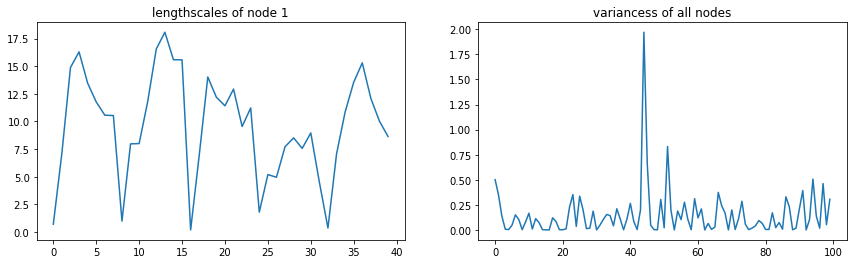

In [74]:
plot_ls_node_k(1)

Fix params, retrain lengthscales

In [68]:
predY0cp=predY0

In [ ]:
model.trainable = False

for l in range(4):
    model.layers[l].kern.trainable = True
    
model.likelihood.trainable = True

maxiter=5000
optimiser = gpflow.train.AdamOptimizer(0.01)

exp_path+="-retrain_kern"
#exp_path="./exp/temp"

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

checkpoint_task = mon.CheckpointTask(checkpoint_dir=exp_path)\
        .with_name('checkpoint')\
        .with_condition(mon.PeriodicIterationCondition(15))\

with mon.LogdirWriter(exp_path) as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task, checkpoint_task] # [print_task, tensorboard_task]
    
       
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)

In [ ]:
%%time
pred_rmse, predY, varY = batch_assess_rmse(model, sample_X.reshape(sample_X.shape[0], -1), sample_Y.reshape(sample_Y.shape[0], -1))
print(pred_rmse)

predY0 = unnormalize_data(predY[:,:,None], mu_trY0, std_trY0).squeeze()

In [ ]:
plt.imshow(varY[:100])
plt.colorbar()

In [ ]:
plt.plot(np.mean(varY, axis=0))

metrics:	[mae | rmse | mape]
ours DGP:	 [3.382, 6.101, 0.072]
yesterday:	 [4.123, 7.806, 0.102]
day-mean:	 [4.052, 7.966, 0.097]
day_median:	 [4.053, 8.203, 0.1]


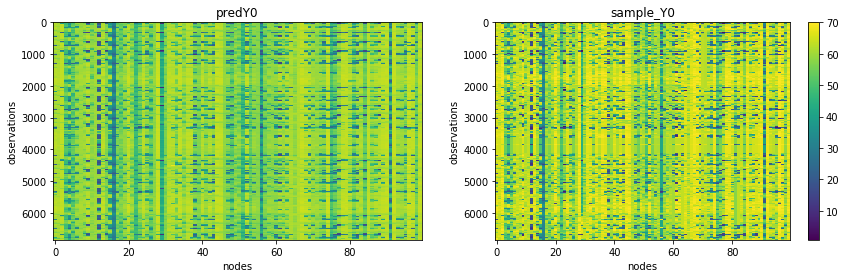

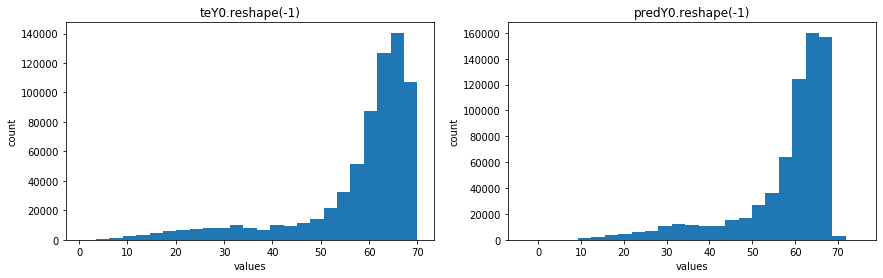

In [57]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_dgp = [np.round(f(predY0, sample_Y0.squeeze()), 3) for f in metrics]
e_last = [np.round(f(sample_X0[:,:,-1], sample_Y0.squeeze()), 3) for f in metrics]
e_ha = [np.round(f(sample_X0[:,:,2:].mean(axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
e_mid = [np.round(f(np.median(sample_X0[:,:,2:], axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('ours DGP:\t', e_dgp)
print('yesterday:\t', e_last)
print('day-mean:\t', e_ha)
print('day_median:\t', e_mid)

# visualization of prediction(mean)
fig, axs = plt.subplots(1, 2)
max_val = sample_Y0.max()*1.1
# for i, to_show in enumerate('predY0,sample_Y0,np.abs(predY0-sample_Y0)'.split(',')):
for i, to_show in enumerate('predY0,sample_Y0'.split(',')):
    im = axs[i].imshow(eval(to_show))
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('nodes'); axs[i].set_ylabel('observations');
fig.colorbar(im, ax=axs[-1])
plt.subplots_adjust(right=2)
plt.show()

# visualization of variance
fig, axs = plt.subplots(1, 2)
for i, to_show in enumerate('teY0.reshape(-1),predY0.reshape(-1)'.split(',')):
    im = axs[i].hist(eval(to_show), bins=25)
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('values'); axs[i].set_ylabel('count');
plt.subplots_adjust(right=2)
plt.show()

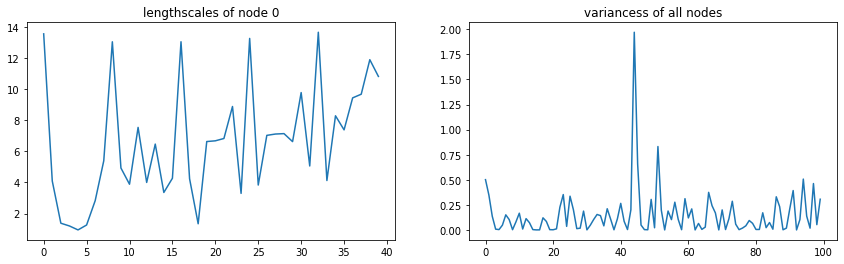

In [58]:
plot_ls_node_k(0)

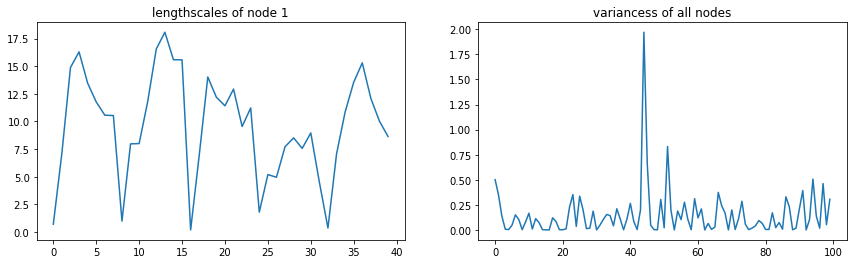

In [59]:
plot_ls_node_k(1)

# Variance analysis

In [60]:
std_varY0 = np.sqrt(varY)*std_trY0.reshape(1,100)

[66 55 92 46 27  7 31 45  1 11]
[1.47175582 1.56355447 1.59830836 1.68837796 1.69846383 1.69992651
 1.71942309 1.99853637 2.03433903 2.13429885]
[73 52 43 88 82 77  9 38 61 12]
[ 9.11100548  9.49251275  9.66221749  9.72510978 10.03507027 10.6115074
 11.4826344  11.73635199 11.86074561 13.98290238]


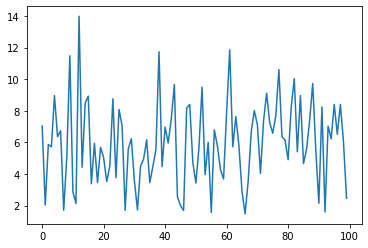

In [66]:
nd_vars = np.mean(std_varY0, axis=0)

plt.plot(nd_vars)

print(np.argsort(nd_vars)[:10])
print(np.sort(nd_vars)[:10])

print(np.argsort(nd_vars)[-10:])
print(np.sort(nd_vars)[-10:])

In [61]:
def correct_rate(predY0, std_varY0, sample_Y0, ndev):
    predY0_ub = predY0 + std_varY0*ndev
    predY0_lb = predY0 - std_varY0*ndev
    tf_mat = np.logical_and(predY0_lb <= sample_Y0, sample_Y0 <= predY0_ub) 
    correct_rate = np.sum(tf_mat) / np.product(tf_mat.shape)
    return correct_rate

In [62]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=1)

0.8419664233576643

In [63]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=2)

0.9450043795620438

In [64]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=3)

0.975407299270073

In [65]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=1.96)

0.9429751824817518

Text(0.5, 1.0, 'Lengthscales of node 1')

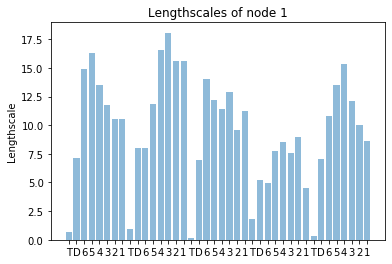

In [67]:
k=1
l=0

axs = plt.gca()
axs.set_title('lengthscales of node %d' % k); axs.set_aspect('auto');
ls = model.layers[l].kern.lengthscales.value
ls0 = ls[k]
idx = np.repeat(adj[k], 8).astype('bool')
ls0n = ls0[idx]

# axs.plot(ls0n)
objects = ('T', 'D', '6', '5', '4', '3', '2', '1')*5
y_pos = np.arange(len(objects))

plt.bar(y_pos, ls0n, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Lengthscale')
plt.title('Lengthscales of node %d' % k)

# Results

|setting|mae|rmse|mape|
|--:|:--|:--|:--|
|--|--|--|--|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->1-5k-rbf|3.585| 6.393| 0.075|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->1-5k-rbf-rt|3.568| 6.369| 0.075|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->2->1-5k-rbf|3.465| 6.238| 0.074|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->2->1-5k-rbf-rt|3.421| 6.159| 0.073|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->2->1->1-5k-rbf|3.46| 6.223| 0.074|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->2->1->1-5k-rbf-rt|3.419| 6.156| 0.073|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->2->1->1->1-5k-rbf|3.438| 6.19| 0.073|
|la-6p-tid-diw-offset3-thdg5-bi-M20-8->2->1->1->1-5k-rbf-rt|3.394| 6.121| 0.072|
|--|--|--|--|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->1-5k-rbf|3.593| 6.41| 0.075|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->1-5k-rbf-rt|3.57| 6.381| 0.075|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->2->1-5k-rbf|3.465| 6.238| 0.074|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->2->1-5k-rbf-rt|3.421| 6.159| 0.073|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->2->1->1-5k-rbf|3.458| 6.24| 0.074|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->2->1->1-5k-rbf-rt|3.394| 6.132| 0.072|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->2->1->1->1-5k-rbf|3.456| 6.223| 0.074|
|la-6p-tv-tid-diw-offset3-thdg5-bi-M20-8->2->1->1->1-5k-rbf-rt|3.382| 6.101| 0.072|